# MS&E 234 Project

### Data cleaning

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from random import sample
import itertools
from collections import defaultdict, Counter
from tqdm.notebook import tqdm
import pickle

### Load data

In [2]:
df_raw = pd.DataFrame()
for i in range(1, 4+1):
    df_raw = pd.concat([df_raw, pd.read_csv(f'../netflix-prize-kaggle-data/combined_data_{i}.txt',
        header=None,
        names=['CustomerID', 'Rating', 'Date'])])
df_raw = df_raw.reset_index(drop = True)
df_raw

,CustomerID,Rating,Date
0,1:,NaN,NaN
1,1488844,3.0,2005-09-06
2,822109,5.0,2005-05-13
3,885013,4.0,2005-10-19
4,30878,4.0,2005-12-26
...,...,...,...
100498272,1790158,4.0,2005-11-01
100498273,1608708,3.0,2005-07-19
100498274,234275,1.0,2004-08-07
100498275,255278,4.0,2004-05-28


### Subset data as in paper (Calandrino 2011)

In [2]:
def buildDataset(df, userList, train):
    print("Entire dataset: 100498277 ratings; 480189 users")
    # Sample 10000 users
    df = df[df['CustomerID'].isin(userList)]
    print(f"Subset of 10000 users: {df.shape[0]} ratings; {df['CustomerID'].nunique()} users")

    if train:
        # Assume each user makes a random 50% of transactions public
        idxs = df[['CustomerID']].reset_index().groupby('CustomerID').agg({'index':lambda x: list(x)}).to_numpy().tolist()
        drop_idxs = []
        for i in range(len(idxs)):
            drop_idxs.append(sample(idxs[i][0], len(idxs[i][0]) // 2))
        drop_idxs = list(itertools.chain(*drop_idxs))
        df = df.drop(drop_idxs)
        print(f'After making 50% private: {df.shape[0]} ratings; {df.CustomerID.nunique()} users')

        # Only consider users with at least 100 public transactions
        df = df[df['CustomerID'].isin(df['CustomerID'].value_counts()[df['CustomerID'].value_counts() > 100].index)]
        print(f'Filter for users with >= 100 public transactions: {df.shape[0]} ratings; {df.CustomerID.nunique()} users')

    # Subset the data to analyze only ratings from July 2005
    df = df[df['Date'].apply(lambda x: type(x) == str and bool(re.match(r'2005-07.*', x)))]
    print(f'Only July 2005: {df.shape[0]} ratings; {df["CustomerID"].nunique()} users')
          
    return df

In [2]:
# extract movie ID's from raw data, combine these with df
# The data files follow the following format:
# Movie ID:
# CustomerID, Rating, Date
# ...

def addMovieInfo(df, movieDF):
    movieRows = np.array(movieDF.index)
    movieIDs = []
    currIdx = 0
    for row in df.itertuples(index = True, name = 'Pandas'):
        currRow = row.Index
        while currIdx < len(movieRows) - 1:
            nextMovieRow = movieRows[currIdx + 1]
            if currRow > nextMovieRow:
                currIdx += 1
            else:
                break
        movieIDs.append(currIdx)
    df["MovieID"] = movieIDs
    df['Day'] = pd.DatetimeIndex(df['Date']).day
    return df

In [3]:
# input: 2 sets x, y
# output: for binary vectors x and y: cosine similarity = |x and y| / sqrt(|x||y|)
def getCosSim(x, y):
    return len(x.intersection(y)) / np.sqrt(len(x) * len(y))

In [4]:
# input: sparse binary adjList
# output: dict of the 50 most similar items and scores, in format: dict[movieID] => ([(items, scores)])
def getSimListDaily(adjList):
    simList = {}
    for key1 in adjList.keys():
        cosSims = []
        for key2 in adjList.keys():
            if key1 == key2:
                continue
            cosSim = getCosSim(adjList[key1], adjList[key2])
            cosSims.append((key2, cosSim))
        simList[key1] = sorted(cosSims, key = lambda x: (-x[1], x[0]))[:50]
    return simList

In [5]:
# input: dataframe of customerIDs, Ratings, Day of Month, and MovieIDs
# input dataframe should contain both public and private data, as the recc system uses all available information
# output: list of 50 related movies and similarity ratings per day
# on each consecutive day, more data is used by the recc system
# uses cosine similarity on a binary matrix
def getSimListMonthly(df):
    # store binary matrix in sparse adjacency list format
    # adjList[movieID] => set of customerIDs
    adjList = defaultdict(set)
    
    simLists = []
    
    for day in tqdm(sorted(df["Day"].unique())):
        # add new movies from today to adjList
        currDF = df[df["Day"] == day]
        for row in currDF.itertuples(index = True, name = 'Pandas'):
            adjList[row.MovieID].add(row.CustomerID)
        
        # compute similarity scores
        currSimList = getSimListDaily(adjList)
        simLists.append(currSimList)
    return simLists

In [8]:
movieDF = df_raw[df_raw['Rating'].isnull()]
userList = sample(df_raw.dropna()['CustomerID'].unique().tolist(), 10000)
dfTrain = buildDataset(df_raw, userList, train = True)
dfTrain = addMovieInfo(dfTrain, movieDF)
dfTest = buildDataset(df_raw, userList, train = False)
dfTest = addMovieInfo(dfTest, movieDF)
dfTrain.to_csv("train/Trial1.csv")
dfTest.to_csv("test/Trial1.csv")

Entire dataset: 100498277 ratings; 480189 users
Subset of 10000 users: 2086064 ratings; 10000 users
After making 50% private: 1045448 ratings; 10000 users
Filter for users with >= 100 public transactions: 806422 ratings; 3159 users
Only July 2005: 35238 ratings; 1999 users
Entire dataset: 100498277 ratings; 480189 users
Subset of 10000 users: 2086064 ratings; 10000 users
Only July 2005: 100667 ratings; 4439 users


In [9]:
simLists = getSimListMonthly(dfTest)

In [10]:
#fileName = 'simLists/Trial1.pkl'
#with open(fileName, 'wb') as handle:
#    pickle.dump(simLists, handle)

In [67]:
fileName = 'simLists/Trial1.pkl'
with open(fileName, 'rb') as handle:
    simLists = pickle.load(handle)

In [68]:
for i in tqdm(range(len(simLists))):
    for key in simLists[i].keys():
        simLists[i][key] = dict(simLists[i][key])

In [3]:
dfTrain = pd.read_csv("train/Trial1.csv", index_col = 0)
dfTest = pd.read_csv("test/Trial1.csv", index_col = 0)

In [4]:
countDF = dfTest.groupby(["CustomerID", "Day"]).count()
print(f"number of (user, date) pairs: {countDF.shape[0]} ")
countDF = countDF[countDF["Rating"] <= 5]
print(f"(user, date) pairs with <= 5 transactions: {countDF.shape[0]}")
validUsers = set(dfTrain["CustomerID"].unique())
countDF = countDF.reset_index()
countDF = countDF[countDF["CustomerID"].isin(validUsers)]
#monthlyCountDF = dfTest.groupby(["CustomerID"]).count()
print(f"filter by users with >= 100 transactions (in the whole dataset): {countDF.shape[0]}")
print("final transaction count: ", countDF["Rating"].sum())
#validUsers = set(monthlyCountDF[(monthlyCountDF["Rating"] > 100).values].index)
#countDF = countDF[countDF["CustomerID"].isin(validUsers)]
#print(f"filter by users with >= 100 transactions (July): {countDF.shape[0]}")
userPairs = countDF[["CustomerID", "Day"]].to_numpy()

# reset countDF to contain full count info
countDF = dfTest.groupby(["CustomerID", "Day"]).count()
countDF = countDF.reset_index()

number of (user, date) pairs: 14732 
(user, date) pairs with <= 5 transactions: 12233
filter by users with >= 100 transactions (in the whole dataset): 7121
final transaction count:  13367


In [5]:
print("> 100 txn users (full dataset): ", len(set(dfTrain["CustomerID"].unique())))
monthlyCountDF = dfTest.groupby(["CustomerID"]).count()
print("> 100 txn users (July): ", len(set(monthlyCountDF[(monthlyCountDF["Rating"] > 100).values].index)))

> 100 txn users (full dataset):  1999
> 100 txn users (July):  197


In [6]:
len(userPairs)

7121

In [7]:
len(np.unique(userPairs[:, 0]))

1826

In [8]:
countDF = dfTest.groupby(["CustomerID", "Day"]).count()
print(f"number of (user, date) pairs: {countDF.shape[0]} ")
countDF = countDF[countDF["Rating"] <= 5]
print(f"(user, date) pairs with <= 5 transactions: {countDF.shape[0]}")
validUsers = set(dfTrain["CustomerID"].unique())
countDF = countDF.reset_index()
countDF = countDF[countDF["CustomerID"].isin(validUsers)]

number of (user, date) pairs: 14732 
(user, date) pairs with <= 5 transactions: 12233


In [9]:
def getScore(searchID, simList):
    if searchID in simList:
        return simList[searchID]
    else:
        return np.nan

In [10]:
def propagatedAux(user):
    # known movies watched by user during July
    aux = dfTrain[dfTrain["CustomerID"] == user]["MovieID"].to_numpy() 
    n = len(aux)
    
    # get subset of days where a rating was given by user
    validDays = countDF[countDF["CustomerID"] == user]["Day"]
    
    prop = dict()
    
    for day in validDays:            
        deltaMatrix = np.zeros((n, n))
        for i in range(n):
            if day > 1:
                if aux[i] not in simLists[day - 2].keys():
                    continue
                lastSimList = simLists[day - 2][aux[i]]
            currSimList = simLists[day - 1][aux[i]]
            
            for j in range(i + 1, n):
                if day == 1:
                    startScore = 0
                else:
                    startScore = getScore(aux[j], lastSimList)
                endScore = getScore(aux[j], currSimList)
                scoreDelta = endScore - startScore
                if np.isnan(scoreDelta):
                    scoreDelta = 0
                deltaMatrix[i][j] = scoreDelta
                deltaMatrix[j][i] = scoreDelta
        #print("day: ", day)
        for i, movieID in enumerate(aux):
            deltaSum = np.sum(deltaMatrix[i])
            #print(f"movie: {movieID} deltaSum: ", deltaSum)
            if deltaSum > 0:
                if movieID not in prop:
                    prop[movieID] = day
    return prop

In [11]:
def filterAux(A, day):
    newA = set()
    for key, value in A.items():
        if value <= day:
            newA.add(key)
    return newA

In [170]:
def getSupports(A, day, T):
    TScores = Counter()
        
    for movieID in A:
        if day > 1:
            if movieID not in simLists[day - 2].keys():
                continue
            lastSimList = simLists[day - 2][movieID]
        else:
            if movieID not in simLists[day - 1].keys():
                continue
        currSimList = simLists[day - 1][movieID]
        
        for movieID2 in T:
            if day > 1:
                if movieID2 not in simLists[day - 2].keys():
                    continue
            else:
                if movieID2 not in simLists[day - 1].keys():
                    continue
            if day == 1:
                startScore = 0
            else:
                startScore = getScore(movieID2, lastSimList)
                if np.isnan(startScore):
                    startScore = getScore(movieID, simLists[day - 2][movieID2])
            endScore = getScore(movieID2, currSimList)
            if np.isnan(startScore):
                startScore = getScore(movieID, simLists[day - 1][movieID2])

            if np.isnan(startScore) and not np.isnan(endScore):
                TScores[movieID2] += 1
            elif endScore > startScore:
                TScores[movieID2] += 1
        
    return TScores

def alg2(fullAux, propAux, day, T, scoreThreshold = 0.1, supportThreshold = 3):
    T = T - fullAux
    A = filterAux(propAux, day)
    n = len(A)
    
    inferences = []
    scores = []
    supportList = []
    
    if n < supportThreshold:
        return inferences, scores, supportList
    
    supports = getSupports(A, day, T)
    for movieID in supports:
        support = supports[movieID]
        score = support / n
        if score > scoreThreshold and support >= supportThreshold:
            inferences.append(movieID)
            scores.append(score)
            supportList.append(support)
    return inferences, scores, supportList

In [171]:
T = set(dfTest["MovieID"].unique())
fullAux = set(dfTrain[dfTrain["CustomerID"] == user]["MovieID"])
soln = set(dfTest[(dfTest["CustomerID"] == user) & (dfTest["Day"] == day)]["MovieID"])
propAux = dict(dfTrain[dfTrain["CustomerID"] == user][["MovieID", "Day"]].to_numpy())

print("fullAux: ", len(fullAux))
print("propAux: ", len(filterAux(propAux, day)))
print("day: ", day)
print("soln (before subtracting): ", soln)
soln = soln - fullAux
    
inferences, scores = alg2(fullAux, propAux, day, T, scoreThreshold = 0.1)
print("soln size: ", len(soln))
print("infer size: ", len(inferences))
print("soln: ", soln)
print("infer: ", inferences)

if len(inferSet) > 0:
    print("user, day: ", user, day)
    print(f"percent inferences: {len(soln.intersection(inferences))} / {len(inferences)}")
    print(f"num solutions correct: {len(soln.intersection(inferences))} / {len(soln)}")

fullAux:  6
propAux:  5
day:  18
soln (before subtracting):  {7444}


ValueError: too many values to unpack (expected 2)

In [178]:
# TRAIN
# fullAux - all train movies ever watched by user
# propAux - dictionary of movies => days
# TEST
# soln - test movies for given user, day pair
def splitTrainTest(user, dfTest, trainRatio):
    temp = dfTest[dfTest["CustomerID"] == user][["MovieID", "Day"]].to_numpy()
    idxs = np.array(sample(range(len(temp)), int(len(temp) * trainRatio)))
    mask = np.full(temp.shape[0], False, dtype=bool)
    if len(idxs) > 0:
        mask[idxs] = True
    fullTrain = temp[mask]
    fullTest = temp[~mask]
    fullAux = set(fullTrain[:, 0])
    propAux = dict(fullTrain)
    solnDict = defaultdict(list)
    for row in fullTest:
        solnDict[row[1]].append(row[0])
    return fullAux, propAux, solnDict

In [199]:
def getInf(trainRatio):
    T = set(dfTest["MovieID"].unique())

    allInf = []
    trainSize = defaultdict(int)
    solnSize = defaultdict(int)

    lastUser = None
    for user, day in tqdm(userPairs):
        #print(user, day)
        if lastUser is None:
            fullAux, propAux, solnDict = splitTrainTest(user, dfTest, trainRatio)
            
        if user != lastUser:
            fullAux, propAux, solnDict = splitTrainTest(user, dfTest, trainRatio)
            lastUser = user

        soln = solnDict[day]

        filteredAux = filterAux(propAux, day)
        
        if len(filteredAux) == 0:
            continue

        if len(soln) == 0:
            continue
            
        trainSize[(user, day)] = len(filteredAux)
        solnSize[(user, day)] = len(soln)

        currInf, currScores, currSupports = alg2(fullAux, propAux, day, T, scoreThreshold = 0.1, 
                                                 supportThreshold = 3)

        
        for i in range(len(currInf)):
            allInf.append((user, day, currInf[i], currScores[i], currSupports[i], currInf[i] in soln))

    return allInf, trainSize, solnSize
    #if len(currInf) > 0:
    #    print("totalInf: ", len(allInf))
    
    #print("soln size: ", len(soln))
    #if len(inferSet) > 0:
        #print("user, day: ", user, day)
        #print(f"percent inferences: {len(soln.intersection(inferSet))} / {len(inferSet)}")
        #print(f"num solutions correct: {len(soln.intersection(inferSet))} / {len(soln)}")

In [200]:
allInfs = []
trainSizes = []
solnSizes = []
trainRatios = [.25, .5, .75]
for i, trainRatio in enumerate(trainRatios):
    allInf, trainSize, solnSize = getInf(trainRatio)
    allInfs.append(allInf)
    print(f"trainRatio{trainRatio}:")
    print("totalInf: ", len(allInf))
    print("unFiltered Accuracy: ", np.sum([x[5] for x in allInf]) / len(allInf))
    trainSizes.append(trainSize)
    solnSizes.append(solnSize)
    fileName = f'results/trainRatio{trainRatio}.pkl'
    with open(fileName, 'wb') as handle:
        pickle.dump(allInfs[i], handle)
    fileName = f'results/trainRatio{trainRatio}TrainSizes.pkl'
    with open(fileName, 'wb') as handle:
        pickle.dump(trainSizes[i], handle)
    fileName = f'results/trainRatio{trainRatio}SolnSizes.pkl'
    with open(fileName, 'wb') as handle:
        pickle.dump(solnSizes[i], handle)


trainRatio0.25:
totalInf:  7013
unFiltered Accuracy:  0.025666619135890488



trainRatio0.5:
totalInf:  10145
unFiltered Accuracy:  0.04110399211434204



trainRatio0.75:
totalInf:  7670
unFiltered Accuracy:  0.04380704041720991


In [81]:
#fileName = 'results/Trial1.pkl'
#with open(fileName, 'wb') as handle:
#    pickle.dump(allInf, handle)

In [13]:
#fileName = 'results/Trial1.pkl'
#with open(fileName, 'rb') as handle:
#    allInf = pickle.load(handle)

In [205]:
# filter inferences using max counts for (user, day) pairs
def filterInf(allInf, solnSize):
    sortedInf = sorted(allInf, key = lambda x: (x[0], x[1], -x[4]))

    lastUser = None
    lastDay = None

    counter = 0
    dailyPredMax = None

    filteredInf = []

    # use fact that we know total transaction count per day to filter inf
    for inf in tqdm(sortedInf):
        user, day, movieID, score, support, label = inf

        if user != lastUser or day != lastDay:
            lastUser = user
            lastDay = day

            dailyPredMax = solnSize[(user, day)]

            counter = 0

        if counter < dailyPredMax:
            filteredInf.append(inf)

        counter += 1
    return filteredInf

In [217]:
filteredInfs = []
for i in range(len(allInfs)):
    filteredInfs.append(filterInf(allInfs[i], solnSizes[i]))

In [218]:
def getFilterMetrics(inf, scoreThreshold, supportThreshold):
    newInf = [x for x in inf if x[3] >= scoreThreshold and x[4] >= supportThreshold]
    Yield = len(newInf)
    if Yield == 0:
        Acc = 0
    else:
        Acc = np.sum([x[5] for x in newInf]) / Yield
    return Acc, Yield

In [220]:
def getAccYieldCurve(filteredInf, supportCutoff):
    accs = []
    yields = []
    for scoreCutoff in np.arange(0, 1, 0.01):
        currAcc, currYield = getFilterMetrics(filteredInf, scoreCutoff, supportCutoff)
        if currYield > 10:
            accs.append(currAcc)
            yields.append(currYield)
    return accs, yields

In [222]:
accList = []
yieldList = []
for i, filteredInf in enumerate(filteredInfs):
    accs, yields = getAccYieldCurve(filteredInf, 3)
    accList.append(accs)
    yieldList.append(yields)

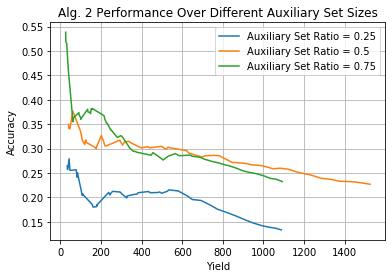

In [226]:
plt.title("Alg. 2 Performance Over Different Auxiliary Set Sizes")
plt.xlabel("Yield")
plt.ylabel("Accuracy")
for i, ratio in enumerate(trainRatios):
    plt.plot(yieldList[i], accList[i], label = f"Auxiliary Set Ratio = {ratio}")
plt.grid()
plt.legend()
plt.savefig("plots/alg2DiffRatios.png", dpi = 200)
plt.show()

In [236]:
print(np.mean(list(trainSizes[0].values())))
print(np.mean(list(trainSizes[1].values())))
print(np.mean(list(trainSizes[2].values())))
print(np.median(list(trainSizes[0].values())))
print(np.median(list(trainSizes[1].values())))
print(np.median(list(trainSizes[2].values())))

6.456361724500526
11.705748175182482
16.568872383524646
2.0
4.0
5.0


In [274]:
def getAccFromAuxSize(filteredInf, trainSize):
    auxCorrect = defaultdict(int)
    auxCounts = defaultdict(int)
    for inf in filteredInf:
        user, day, movieID, score, support, label = inf
        if score < 0.5:
            continue
        auxSize = trainSize[(user, day)]
        if label:
            auxCorrect[auxSize] += 1
        auxCounts[auxSize] += 1

    data = [(key, auxCorrect[key] / auxCounts[key]) for key in auxCounts if auxCounts[key] >= 5]
    return [x[0] for x in data], [x[1] for x in data]

In [275]:
xs = []
ys = []
for i in range(len(filteredInfs)):
    x, y = getAccFromAuxSize(filteredInfs[i], trainSizes[i])
    xs.append(x)
    ys.append(y)

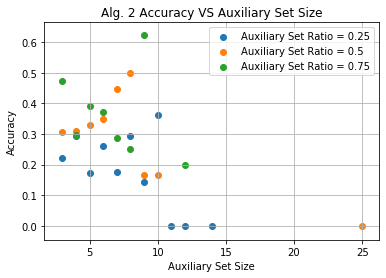

In [277]:
plt.title("Alg. 2 Accuracy VS Auxiliary Set Size")
plt.xlabel("Auxiliary Set Size")
plt.ylabel("Accuracy")
for i, ratio in enumerate(trainRatios):
    plt.scatter(xs[i], ys[i], label = f"Auxiliary Set Ratio = {ratio}")
plt.grid()
plt.legend()
plt.savefig("plots/alg2AuxSize.png", dpi = 200)
plt.show()

In [105]:
'''
supportCutoffs = [3, 5, 7, 9]
accList = []
yieldList = []
for supportCutoff in [3, 5, 7, 9]:
    accs, yields = getAccYieldCurve(supportCutoff)
    accList.append(accs)
    yieldList.append(yields)
'''

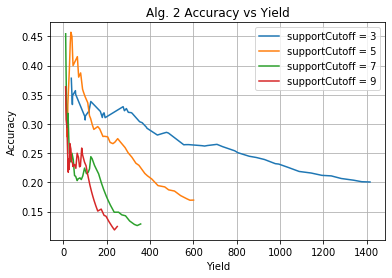

In [106]:
'''
plt.title("Alg. 2 Accuracy vs Yield")
plt.xlabel("Yield")
plt.ylabel("Accuracy")
for i, cutoff in enumerate(supportCutoffs):
    plt.plot(yieldList[i], accList[i], label = f"supportCutoff = {cutoff}")
plt.grid()
plt.legend()
plt.savefig("plots/alg2AccYield.png", dpi = 200)
plt.show()
'''

In [24]:
movieRanks = dfTest.groupby("MovieID").count()["CustomerID"]
movieRanks = movieRanks.reset_index()
movieRanks["CustomerID"] = movieRanks["CustomerID"].to_numpy().argsort().argsort()
movieRanks = dict(movieRanks.to_numpy())

In [114]:
max(list(movieRanks.values()))

8511

In [25]:
allSolns = []

lastUser = None
for user, day in tqdm(userPairs):
    fullAux = set(dfTrain[dfTrain["CustomerID"] == user]["MovieID"])
    soln = set(dfTest[(dfTest["CustomerID"] == user) & (dfTest["Day"] == day)]["MovieID"])
    soln = soln - fullAux
    if len(soln) > 0:
        allSolns.append((user, day, soln))

In [26]:
correctInfDict = defaultdict(set)
for movieID, user, day in [(x[2], x[0], x[1]) for x in filteredInf if x[5]]:
    correctInfDict[movieID].add((user, day))

In [27]:
correct = defaultdict(int)
total = defaultdict(int)

for user, day, solns in allSolns:
    for movieID in solns:
        if (user, day) in correctInfDict[movieID]:
            correct[movieID] += 1
        total[movieID] += 1

In [28]:
probs = []

for movieID in total.keys():
    probs.append((movieRanks[movieID], correct[movieID] / total[movieID]))
    
probs = sorted(probs, key = lambda x: x[0])

In [29]:
xs = []
ys = []
counter = 0
sampleRate = 80

currRanks = []
currProbs = []
for rank, prob in probs:
    currRanks.append(rank)
    currProbs.append(prob)
    counter += 1
    if counter == sampleRate:
        counter = 0
        xs.append(np.mean(currRanks))
        ys.append(np.mean(currProbs))
        currRanks = []
        currProbs = []

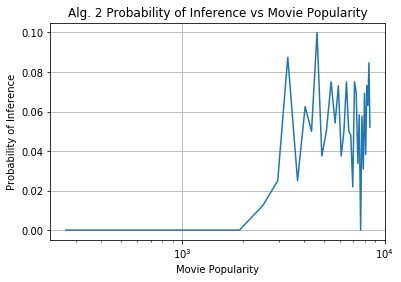

In [30]:
plt.title("Alg. 2 Probability of Inference vs Movie Popularity")
plt.xlabel("Movie Popularity")
plt.ylabel("Probability of Inference")
plt.xscale('log')
plt.plot(xs, ys)
plt.grid()
plt.savefig("plots/alg2Pop.png", dpi = 200)
plt.show()